In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import pickle
import datetime
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt
from scipy.stats import binned_statistic

In [4]:
dir = '../../data/rothera/netcdfs/20230915'

In [5]:
listfiles = os.listdir(dir)
listfiles

ku_files = sorted([f for f in listfiles if 'Ku-Scat' in f])[0:1]
ka_files = sorted([f for f in listfiles if 'Ka-Scat' in f])[0:1]

ku_files

['kuka_stare_decon_Ku-Scat20230915-181453.nc']

Text(0, 0.5, 'y distance (m)')

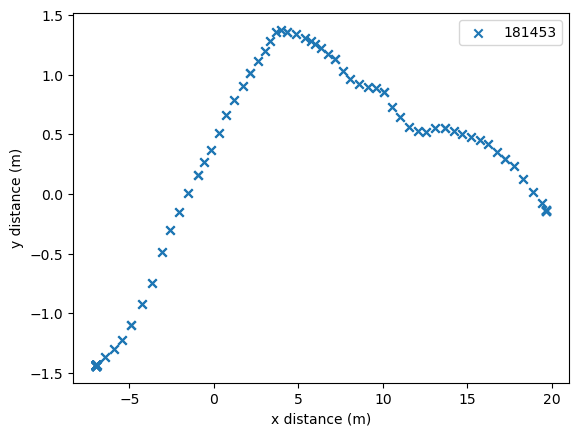

In [6]:

x,y=kt.plot_pos(ku_files[0],dir,plot=False)

x0 = -2300414.994491106; y0 = 923485.871699531

xy_dict = {}
for f in ku_files:

    x,y=kt.plot_pos(f,dir,x0=x0,y0=y0)
    xy_dict[f]=(x,y)
plt.legend()
plt.xlabel('x distance (m)')
plt.ylabel('y distance (m)')

# plt.xlim(-20,5)
# plt.ylim(-20,5)

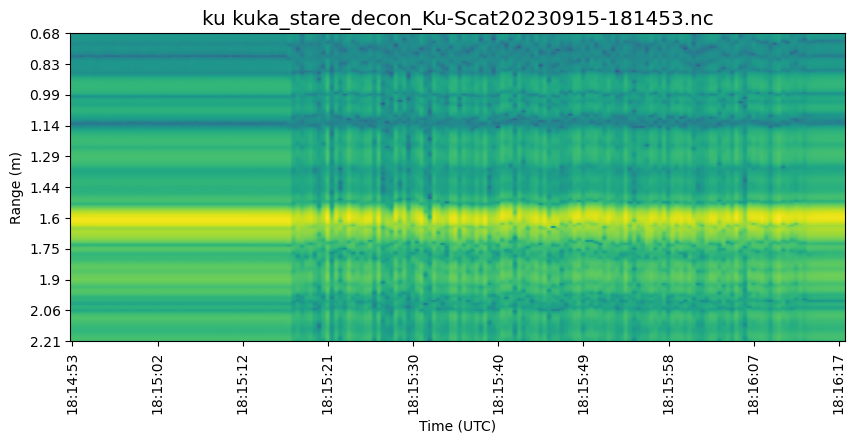

In [7]:
for f in ku_files[0:]:
    kt.plot_file(f,'ku',dir)

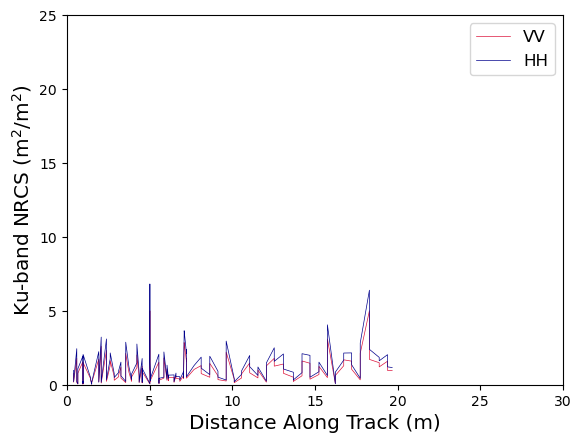

In [17]:
foi = ku_files[0]
d = Dataset(f'{dir}/{foi}')
x,y=xy_dict[foi]

range = np.array(d['range'])

time_offset_s=0
times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

mintime = kt.get_time_index(datetime.datetime(2023,9,15,18,15,20),times)
maxtime = kt.get_time_index(datetime.datetime(2023,9,15,18,16,10),times)

mintime = np.argmin(x)
maxtime = np.argmax(x)

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)


nrcs = pd.DataFrame(kt.get_nrcs(d,'ku'))

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)
xdiff = np.diff(x)
ydiff = np.diff(y)
speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
speed=list(speed)+[0]
nrcs['along_track']=along_track
nrcs['speed']=speed


nrcs_return = nrcs.iloc[mintime:maxtime]

nrcs_return = nrcs_return[nrcs_return['corr']<0.999]
nrcs_return.reset_index(inplace=True)

nrcs_return = nrcs_return.sort_values('along_track').reset_index()

nrcs_return = nrcs_return[nrcs_return['along_track']<30]

plt.plot(nrcs_return['along_track'],
         nrcs_return['vv'],
         label='VV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['hh'],
         label='HH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ku-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')



# plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
plt.ylim(0,25)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

(array([52., 22., 20., 15.,  4.,  3.,  1.,  0.,  0.,  2.]),
 array([0.03458939, 0.53172824, 1.02886708, 1.52600592, 2.02314476,
        2.5202836 , 3.01742244, 3.51456128, 4.01170012, 4.50883897,
        5.00597781]),
 <BarContainer object of 10 artists>)

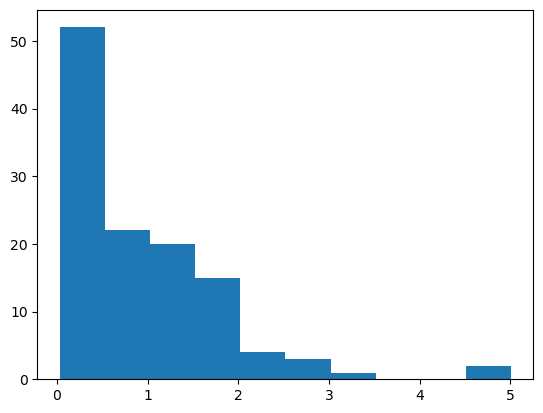

In [18]:
plt.hist(nrcs_return['vv'])

In [19]:
pickle.dump(nrcs_return,open('../../data/pickles/NRCS_915_KU.p','wb'))

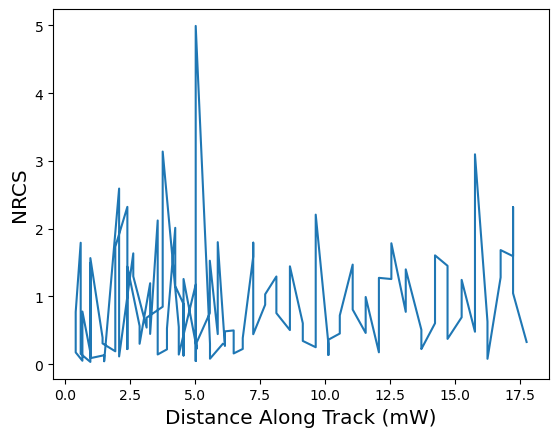

0.8876983322482379


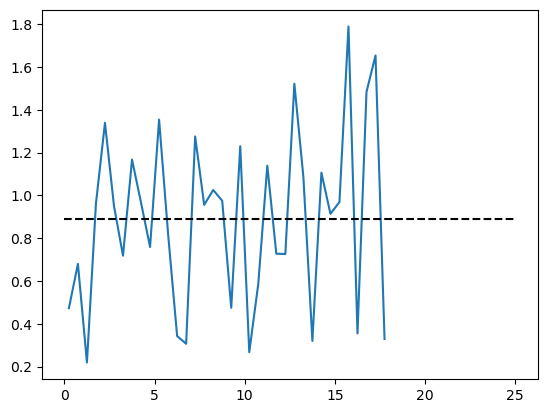

In [19]:
nrcs = kt.get_nrcs(d,'ku')


import pickle
pickle_file = '../data/pickles/915_trans.p'
pickle.dump( (along_track,nrcs), open(pickle_file,'wb'))

plt.plot(along_track[mintime:maxtime],nrcs['vv'][mintime:maxtime])
bs = binned_statistic(along_track[mintime:maxtime],nrcs['vv'][mintime:maxtime],
                      statistic='mean',bins=np.arange(0,26.1,0.5))

plt.ylabel('NRCS',fontsize='x-large')
plt.xlabel('Distance Along Track (mW)',fontsize='x-large')
# plt.ylim(0,25)
# plt.xlim(0,30)

plt.show()

bin_centres = np.arange(0.25,26.01,0.5)

plt.plot(bin_centres,bs[0])

thresh=25

mean = np.nanmean(bs[0][bin_centres<thresh])

plt.plot([0,thresh],[mean,mean],color='k',ls='--')

print(mean)

plt.show()

In [20]:
mintime,maxtime

(57, 165)